# Gibbs Sampling and LDA
    Bailey Smith
    February 1 2018

In [30]:
import math
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import invgamma
from scipy.special import gammaln
from scipy.stats import gaussian_kde

## Gibbs sampling

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).

In [24]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    # initialize
    N = len(y)
    mu = np.mean(y)
    sigma2 = np.var(y)
    all_mus = [mu]
    all_sigmas = [sigma2]
    
    # Update (get n samples)
    for k in range(n_samples):
        # Update tau, nu, alpha and beta
        tau_star2 = 1/(1/tau2 + N/sigma2)
        nu_star = tau_star2 * (nu/tau2 + 1/sigma2*math.fsum(y))
        alpha_star = alpha + N/2
        beta_star = beta + .5*math.fsum((y - mu)**2)
        
        # Sample with updated variables
        mu = norm.rvs(nu_star, scale=np.sqrt(tau_star2))
        sigma2 = invgamma.rvs(alpha_star, scale=beta_star)
        
        # Save new mu and sigma2
        all_mus.append(mu)
        all_sigmas.append(sigma2)
        
    return all_mus, all_sigmas

In [25]:
# initialize
y = np.load("examscores.npy")
nu = 80
tau2 = 16
alpha = 3
beta = 50
samples = 1000
all_mus, all_sigmas = gibbs(y, nu, tau2, alpha, beta, samples)

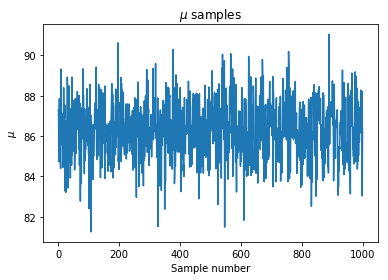

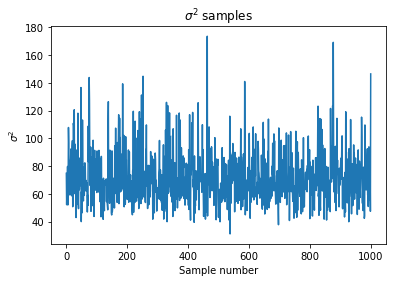

In [26]:
# Plot mu samples
plt.plot(all_mus)
plt.title("$\mu$ samples")
plt.xlabel("Sample number")
plt.ylabel("$\mu$")
plt.show()

# Plot sigma samples
plt.plot(all_sigmas)
plt.title("$\sigma^2$ samples")
plt.xlabel("Sample number")
plt.ylabel("$\sigma^2$")
plt.show()

## KDE

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

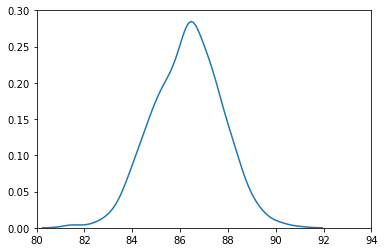

In [27]:
# Get kernal density estimate for mus
mu_kernel = gaussian_kde(all_mus)
x_min = min(all_mus) - 1
x_max = max(all_mus) + 1
x = np.arange(x_min, x_max, step=0.1)

# Plot kernal density estimate
plt.plot(x,mu_kernel(x))
plt.xlim(80,94)
plt.ylim(0,.3)
plt.show()

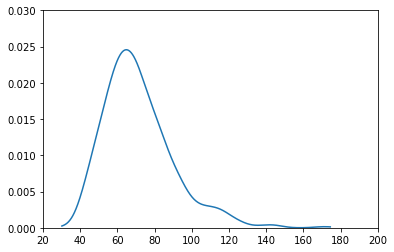

In [28]:
# Get kernal density estimate for sigmas
sigma_kernel = gaussian_kde(all_sigmas)
x_min = min(all_sigmas) - 1
x_max = max(all_sigmas) + 1
x = np.arange(x_min, x_max, step=0.1)

# Plot kernal density estimate
plt.plot(x,sigma_kernel(x))
plt.xlim(20,200)
plt.ylim(0,.03)
plt.show()

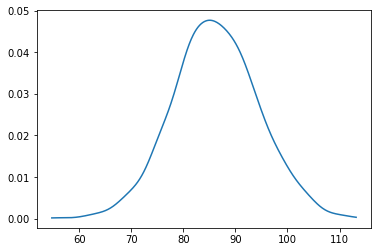

In [31]:
# Get sample scores
ys = stats.multivariate_normal.rvs(all_mus, cov=all_sigmas)

# Kernel density estimator of your sampled scores
kde = gaussian_kde(ys)
x_min = min(ys) - 1
x_max = max(ys) + 1
x = np.arange(x_min, x_max, step=0.1)

plt.plot(x,kde(x))
plt.show()

## Initialize LDA

Implement `LDACGS.initialize()`.
By randomly assigning initial topics, fill in the count matrices and topic assignment dictionary.
In this method, you will initialize the count matrices (among other things).

## Topic Assignment

Complete `LDACGS._sweep()`, which needs to iterate through each word of each document.
It should call `LDACGS._conditional()` to get the conditional distribution at each iteration.


## Sample

Complete `LDACGS.sample()`.
The argument `filename` is the name and location of a .txt file, where each line is considered a document.
The corpus is built by `LDACGS.buildCorpus()`, and stopwords are removed (if argument `stopwords` is provided).
Burn in the Gibbs sampler, computing and saving the log-likelihood with the method `_loglikelihood()`.
After the burn in, iterate further, accumulating your count matrices, where you only add every `sample_rate`th iteration. Also save each log-likelihood.

In [5]:
class LDACGS:
    """Do LDA with Gibbs Sampling."""

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        with open(filename, 'r') as infile:
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        self.documents = []
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        """Initialize the three count matrices."""
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (i,j) entry of self.nmz is the number of words in document i assigned to topic j.
        self.nmz = np.zeros((self.n_docs, self.n_topics))
        # The (i,j) entry of self.nzw is the number of times term j is assigned to topic i.
        self.nzw = np.zeros((self.n_topics, self.n_words))
        # The (i)-th entry is the number of times topic i is assigned in the corpus.
        self.nz = np.zeros(self.n_topics)

        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z

        for m in range(self.n_docs):
            for i in self.documents[m]:
                w = self.documents[m][i]
                # Get random topic assignment, i.e. z = ...
                z = np.random.randint(0,self.n_topics,1)
                # Increment count matrices
                self.nmz[m,z] += 1
                self.nzw[z,w] += 1
                self.nz[z] += 1
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m,i)] = z

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
        for i in range(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            if not i % sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz

    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist / np.sum(dist)

    def _sweep(self):
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i-th word in document m.
                w = self.documents[m][i]
                # Retrieve topic assignment for i-th word in document m.
                z = self.topics[(m,i)]
                # Decrement count matrices.
                self.nmz[m,z] -= 1
                self.nzw[z,w] -= 1
                self.nz[z] -= 1
                # Get conditional distribution. theta n (use in categorical)
                theta = self._conditional(m, w)
                # Sample new topic assignment. categorical draw
                z = np.argmax(np.random.multinomial(1, theta)) # 1 multinomial sample
                # Increment count matrices.
                self.nmz[m,z] += 1
                self.nzw[z,w] += 1
                self.nz[z] += 1
                # Store new topic assignment.
                self.topics[(m,i)] = z
                

    def _loglikelihood(self):
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik

## Observe the amount of time the burn in takes

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Plot the log-likelihoods. 

In [6]:
topics = 20
burnin = 100
n_samples = 10
sweep = 10
stop = 'stopwords.txt'
filename = 'reagan.txt'
lda = LDACGS(topics)

lda.sample(filename, burnin, sweep, n_samples, stopwords_file=stop)

In [7]:
log_likelihoods = lda.logprobs

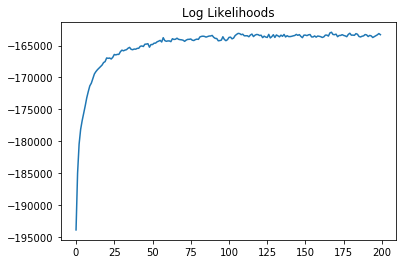

In [8]:
plt.plot(log_likelihoods)
plt.title("Log Likelihoods")
plt.show()

## Apply LDA to Reagan's addresses

Using `topterms()` to examine the topics for Reagan's addresses.
Come up with labels for each topic.

In [20]:
i = 0
topics = ['Government Processes','Government Unification','Economy','Independence','Work Force',
          'Family Welfare','Shelter','Women\'s Rights','Patriotism','Government Administration',
          'Executive Orders','Nicaragua Democracy','State of the Union','Space Development','Cold War',
          'Chicago Development','Abortion','Economic Development','Government Spending',"filler words (junk)"]
for list_ in lda.topterms():
    print(topics[i],'\n', list_,'\n')
    i+=1

Government Processes 
 ['budget', "let's", 'time', 'american', 'balanced', 'give', 'veto', 'federal', 'bill', 'government'] 

Government Unification 
 ['bipartisan', 'commission', 'join', "i'm", 'senate', 'protect', 'plan', 'meet', 'majority', 'americans'] 

Economy 
 ['tax', 'economic', 'rates', 'interest', 'inflation', 'rate', 'government', 'program', '--', 'percent'] 

Independence 
 ['hope', 'called', 'revolution', 'people', 'government', 'stop', 'freedom.', 'start', 'day', 'man'] 

Work Force 
 ['private', 'jobs', 'job', 'programs', 'work', 'sector', 'legislation', 'americans', 'american', 'people'] 

Family Welfare 
 ['children', 'family', 'families', 'school', 'education', 'back', 'america', 'begin', 'parents', 'day'] 

Shelter 
 ['continue', 'full', 'year.', 'welfare', 'fund', 'taxes', 'work', 'fair', 'support', 'housing'] 

Women's Rights 
 ['years', 'states', '.', 'ago', 'women', 'time', 'united', 'rising', "we've", 'men'] 

Patriotism 
 ['america', '--', 'people', 'american'